# Table of content

0. [Theory](#theory)<br>
    0.1 [Literature](#literature)<br>
    0.2 [AlphaXENAS](#alphaxenas)<br>
    0.3 [Implementation](#implementation)<br>
1. [Loading data](#loaddata)<br>
2. [NAS with efficient multiple MCTS expansions](#nas1)<br>
    2.1. [Train/Search](#train1)<br>
    2.2. [Results](#results1)<br>
    2.3. [Retraining the model for more epochs](#retrain11)<br>
    2.4. [Retraining the model for more epochs and 18 normal cells](#retrain12)<br>
3. [NAS with efficient one MCTS expansions](#nas2)<br>
    3.1. [Train/Search](#train2)<br>
    3.2. [Results](#results2)<br>
    3.3. [Retraining the model for more epochs](#retrain21)<br>
    3.4. [Retraining the model for more epochs and 18 normal cells](#retrain22)<br>

<a id='theory'></a>
# 0. Theory

<a id='literature'></a>
## 0.1. Literature

This project is about Neural Architecture Search (NAS) using reinforcement learning. First, it was used in <br>
<br>
<b>NEURAL ARCHITECTURE SEARCH WITH REINFORCEMENT LEARNING</b><br> Barret Zoph, Quoc V. Le 2016 [Link](https://arxiv.org/abs/1611.01578)
<br><br>
using 800 GPUs. This results were followed by papers, which <br><br>
a) Improved the training time for child models by sharing weights <br>
<br>
<b>Efficient Neural Architecture Search via Parameter Sharing</b><br> Hieu Pham, Melody Y. Guan, Barret Zoph, Quoc V. Le, Jeff Dean 2018 [Link](https://arxiv.org/abs/1802.03268)
<br><br>
b) Improved the search exploration of different network architectures by using Monte Carlo Tree Search (MCTS) <br>
<br>
<b>AlphaX: eXploring Neural Architectures with Deep Neural Networks and Monte Carlo Tree Search</b><br>Linnan Wang, Yiyang Zhao, Yuu Jinnai, Rodrigo Fonseca [Link](https://arxiv.org/abs/1805.07440)

Additionally, <br><br>
<b>DEEP LEARNING SCALING IS PREDICTABLE, EMPIRICALLY</b><br>
Joel Hestness, Sharan Narang, Newsha Ardalani, Gregory Diamos, Heewoo Jun, Hassan Kianinejad, Md. Mostofa Ali Patwary, Yang Yang, Yanqi Zhou 2017 [Link](https://arxiv.org/pdf/1712.00409.pdf)<br><br>
showed, that there is a linear relationship between dataset size and accuracy. This relationship is independent of the network architecture and depends on the machine learning problem. Therefore, their conclusion is, that network architecture can be searched with a smaller dataset and finally, the best architecture will be trained with the full dataset. 

<a id='alphaxenas'></a>
## 0.2. AlphaXENAS

AlphaXENAS combines the improvements in exploring the search space and training child network faster:

<img src="./src/alphaxenas_intersect.png" width="600">

AlphaXENAS combines the improvements from all paper above. It uses a reinforcement learning algorithm

<img src="./src/alphaxenas_rl.png" width="600">

, where the coach is driven by a Monte Carlo Tree Search (MCTS) guided by an LSTM neural network. The MCTS selects the next best action (operation) based on:

<img src="./src/alphaxenas_mcts_formula.png" width="300">

where <br>
$Q_{sa}$ := is the estimated accuracy for a given state s and action a<br>
$c$ := is the exploration parameter<br>
$P_{s}$ := is initial probability vector<br>
$N_{s}$ := is the number how often state s was visited<br>
$N_{sa}$ := is the number how often state s and action a was visited

a state s is a sequence of current chosen operations<br>
an action a is a valid next operation for a sequence of actions a<br>
<br>
the sequence of action defines the neural network architecture of the child

The MCTS trades-off between actions with a high accuracy and actions haven't often visited, yet. It is a upper confidence estimations.

The LSTM model initialize $P_{s}$ and $Q_{sa}$ for non-visited s, (s,a).

<img src="./src/alphaxenas_pseudocode.png" width="450">

The ChildNetwork is a convolutional neural network with a special structure to reduce the search space. <br>
A ChildNetwork has Nx Normal Cells (here N is 12 or 18) and each NormalCell is defined by B blocks (here B is 4).<br>
Each block:
<li>takes 2 input tensor from previous normal cells or blocks
<li>for each input tensor defines an operation (e.g. convolution 3x3, identity)
<li>defines a combine operation (add or concat)

<img src="./src/alphaxenas_childnetwork.png" width="600">

The coach has to predict B block structures and each block has 5 decision (actions / operations):
<li>2 indices, which defines the input tensor
<li>2 operations
<li>1 combine operation

<img src="./src/alphaxenas_coachpred.png" width="600">

The operations are defined in action_space and combine_op. Each ChildNetwork shares the weight for the operators in each possible index.

<a id='implementation'></a>
## 0.3. Implementation

The jupyter notebook initialize the Coach class. The coach class initalize the LSTM model and MCTS objects.
On demand a child network is initalized in the coach or MCTS class and trained. <br>In the search expansion, a child network is trained only for 1 epoch and its validation accuracy is observed. If the MCTS finds a final architecture, this child network is trained for 6 epochs and its validation accuracy is observed. The LSTM model is only trained on final architecture accuracies.<br>
The coach initalize the shared weights and stores/reloads weights from disk after each child model is trained. That keeps the session smaller and does not contain old child model weights.

Each ChildNetwork starts with a 1x1 convolution. 
If the number of input channels does not fit (e.g. concating 2 tensors with 32 channels), then a 1x1 convolution is added dynamically to reduce the dimensions back to 32. These dynamically added 1x1 convolutions do not share weights and therefore it is always required to train a model. After the normal cells, a average pooling and one dense layer are applied. Child Models uses SDG with momentum and learning rate decay (similar to ResNet and DenseNet). Training is done with data augmentation similar to ResNet/DenseNet - using random crops, horizonzal flips and whitening.

The coach is trained via jupyter notebook for 3-4 days. As a jupyter conenction would timeout for this timeframe, the library papermill is used to execute notebooks from the command line. All classes log information to textfiles, which can be monitored during training process via opening with jupyter notebook.

Example:
<add>

<a href="./src/logs.txt">Logs.txt</a>

This jupyter notebook contains comments and explanations. 
For more information, each function/class have inline comments based on the google python template.

The best childnetwork architectures are saved to tensorboard and can be viewed by 
```cmd
tensorboard --logdir='./tensorboard_log/'
```

<img src="./src/alphaxenas_exampletensorboard.png" width="200">

<a id='loaddata'></a>
# 1. Loading data

Loading libraries

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import tensorflow as tf
import numpy as np
import os

from alphaxenas.data_utils import read_data, saveObjWithPickle, createPath
from alphaxenas.model_utils import get_weights, create_weights, log_to_textfile
from alphaxenas.model_utils import print_files_to_jupyter, load_pickle, plot_mcts_resuts
from alphaxenas.model_utils import get_index_best_archteicture, print_diff_architectures_to_jupyter
from alphaxenas.child_model import ChildModel
from alphaxenas.controller_lstm import LSTMModel
from alphaxenas.controller_mcts import MCTS
from alphaxenas.controller_coach import Coach

Downloading the training/test data and stored models from AWS S3 and unzip them

In [10]:
# training data (166 MB)
if not os.path.exists('./data/'):
    wget_cmd = 'wget https://s3-eu-west-1.amazonaws.com/bsopenbucket/e6040/data.zip'
    unzip_cmd = 'unzip data.zip'
    os.system(wget_cmd)
    os.system(unzip_cmd)

# pretrained data (380 MB)
if not os.path.exists('./exp/'):
    wget_cmd = 'wget https://s3-eu-west-1.amazonaws.com/bsopenbucket/e6040/exp.zip'
    unzip_cmd = 'unzip exp.zip'
    os.system(wget_cmd)
    os.system(unzip_cmd)

# tensorboard data (11 MB)
if not os.path.exists('./tensorboard_log/'):
    wget_cmd = 'wget https://s3-eu-west-1.amazonaws.com/bsopenbucket/e6040/tensorboard_log.zip'
    unzip_cmd = 'unzip tensorboard_log.zip'
    os.system(wget_cmd)
    os.system(unzip_cmd)

Loading the data (using scripts from DenseNet to make it comparable)

In [11]:
data_path = 'data/cifar10'

In [12]:
images, labels = read_data(data_path)
N = images['train'].shape[0]

--------------------------------------------------------------------------------
Reading data
data/cifar10/data_batch_1
data/cifar10/data_batch_2
data/cifar10/data_batch_3
data/cifar10/data_batch_4
data/cifar10/data_batch_5
data/cifar10/test_batch
Prepropcess: [subtract mean], [divide std]
mean: [125.34512 122.94169 113.83898]
std: [63.02383 62.13708 66.74233]


Defining the action space. From which operation can the Coach choose from: <br>
<li> conv 3x3
<li> conv 5x5
<li> conv 7x7
<li> conv 1x1
<li> identity (skip connection)
<li> separable conv 3x3
<li> separable conv 5x5
<li> separable conv 7x7
<li> maxpool 3x3
<li> avgpool 3x3
<br><br>
Original, max-/avgpool 5x5, 7x7 are supported, as well. But to reduce the search space, only 3x3 sizes are used

In [13]:
action_space = {}
action_space[0] = {}
action_space[0]['name'] = 'conv_3x3'
action_space[0]['shape'] = (3,3)
action_space[0]['type'] = 'conv'
action_space[1] = {}
action_space[1]['name'] = 'conv_5x5'
action_space[1]['shape'] = (5,5)
action_space[1]['type'] = 'conv'
action_space[2] = {}
action_space[2]['name'] = 'conv_7x7'
action_space[2]['shape'] = (7,7)
action_space[2]['type'] = 'conv'
action_space[3] = {}
action_space[3]['name'] = 'conv_1x1'
action_space[3]['shape'] = (1,1)
action_space[3]['type'] = 'conv'
action_space[4] = {}
action_space[4]['name'] = 'id_'
action_space[4]['shape'] = (1,1)
action_space[4]['type'] = 'id'
action_space[5] = {}
action_space[5]['name'] = 'convsep_3x3'
action_space[5]['shape'] = (3,3)
action_space[5]['type'] = 'convsep'
action_space[6] = {}
action_space[6]['name'] = 'convsep_5x5'
action_space[6]['shape'] = (5,5)
action_space[6]['type'] = 'convsep'
action_space[7] = {}
action_space[7]['name'] = 'convsep_7x7'
action_space[7]['shape'] = (7,7)
action_space[7]['type'] = 'convsep'
action_space[8] = {}
action_space[8]['name'] = 'maxpool_3x3'
action_space[8]['shape'] = (3,3)
action_space[8]['type'] = 'maxpool'
action_space[9] = {}
action_space[9]['name'] = 'avgpool_3x3'
action_space[9]['shape'] = (3,3)
action_space[9]['type'] = 'avgpool'

Defining the combine operation space. From which operation can the Coach choose from: <br>
<li> add
<li> concatonate (by channel dimension)

In [14]:
combine_op = {}
combine_op[0] = 'add'
combine_op[1] = 'concat'

Define some hyperparameters

In [15]:
no_channels_start = 32  # number of default convolutional channels per layer (mainly used)
B = 4                   # Number of blocks per normal cell
N_convcells = 12        # Number of normal cells
N_numberofconv = 1      # Not used anymore, keep 1 to support everything

In [16]:
tf.reset_default_graph()

Combine some hyperparemeters to list

In [17]:
global_ops = []
global_param = [N_numberofconv, N_convcells, B, action_space, no_channels_start]

<a id='nas1'></a>
# 2. NAS with efficient multiple MCTS expansions

In this section, a coach (AlphaXENAs) will be trained with multiple MCTS:<br><br>

For each states, the MCTS search are executed 12 times. After 16 coach iterations, a new MCTS is initialized and learns from scratch. The LSTM model should initalize new states better. Results are saved on the fly in the according folders.<br>
The log files of the Coach can be viewed under $\lt$path$\gt$/Couch/log.txt

<a id='train1'></a>
## 2.1. Train/Search

In [18]:
# Dont execute as it takes 4 days to train
if False:
    """
        Function Coach.__init__

        Initialize the Couach - save paramaters as attributes

        Args:
            path (str): Directory to store all files
            GLOBAL_WEIGHTS (dict): Dictonary with shared tensorflow weights
            num_learning_iteration (int): Number of iteration to train 
            num_expansions (int): Number of tree search for a given state
            B (int): Number of inconv cells
            action_space (dict): Dictionary with possible neural network operations + weights
            combine_op (dict): Dictionary with possible combine operations + weights
            size_lstm (int): Size of hidden layer in LSTM; 
            sess (None): Not used anymore
            max_replay_size (int): Number of replay size to train LSTM
            images (dict): Images used for training ChildModel
            labels (dict): Labels used for training ChildModel 
            global_ops (list): Not used anymore 
            global_param (list): List with some global parameters
            no_channels_start (int): Number of channels in convolution layer
            search_perc_range (list): Percentage range of data used for child model (only first value is used)
            search_epoch_range (list): Number of epochs range for child model (only first value is used)
            N_convcells_range (int): Number of convcells used
            no_for_uniform (int): Number of learning iteration (Tree), which uses a uniform distribution for Ps
            new_mcts_every_i (int): Every number of learning iteration (Tree), reinitizalize MCTS tree
            alphax_version (boolean): If True other MCTS formula is used (based on AlphaX paper)
            debug_no_trainig (boolean): If True no ChildModel are trained and only dummy value is returned
        
        Attributes:
            num_actions (int): Number of total actions possible (used for LSTM prediction)
            full_examples (list): Stores replay for training LSTM
            max_noimprovements (int): Stop training ChildModel if does not improve over number of epochs
            max_iteration (int): Number of maximal training steps in ChildModel
            lr_iteration_step (list): Epochs when learning rate is decayed in ChildModel
            max_epochs (int): Number of epochs for training ChildModel
            no_global_variables (boolean): If True, no global variables are trained in ChildModel
            lstm_batchsize (int): Batchsize for training LSTM model
            lstm_learning_rate (float): Learning rate for LSTM model
            no_trained_in_search (int): Counter for number of ChildModel in MCTS Search trained
            no_trained_final (int): Counter for number of ChildModel trained in the end of one iteration_learning
    """
    coach = Coach('exp/MultipleMCTS', 
                  [], 
                  num_learning_iteration = 1000, 
                  num_expansions = 12,
                  B = B,
                  action_space = action_space, 
                  combine_op = combine_op,
                  size_lstm = 100, 
                  sess = None,
                  max_replay_size = 1000, 
                  images = images, 
                  labels = labels, 
                  global_ops = global_ops, 
                  global_param = global_param,
                  no_channels_start = no_channels_start,
                  search_perc_range = [0.3, 0.5],
                  search_epoch_range = [6, 6],
                  N_convcells_range = [6, 7],
                  no_for_uniform = 16, 
                  new_mcts_every_i = 16,
                  alphax_version = False,
                  debug_no_trainig = False
                 )
    coach.train()

In [ ]:
# Execute trainig in debug modus (no child training) - can be executed for testing/grading
coach = Coach('exp/MultipleMCTS_debug', 
              [], 
              num_learning_iteration = 32, # less iterations
              num_expansions = 12,
              B = B,
              action_space = action_space, 
              combine_op = combine_op,
              size_lstm = 100, 
              sess = None,
              max_replay_size = 1000, 
              images = images, 
              labels = labels, 
              global_ops = global_ops, 
              global_param = global_param,
              no_channels_start = no_channels_start,
              search_perc_range = [0.3, 0.5],
              search_epoch_range = [6, 6],
              N_convcells_range = [6, 7],
              no_for_uniform = 16, 
              new_mcts_every_i = 16,
              alphax_version = False,
              debug_no_trainig = True
             )
coach.train()

<a id='results1'></a>
## 2.2. Results

First, all log files are printed to jupyter:<br>
<br>
Each new search from state (0, 0) (start state) is indicated with
```
###################################### New Search ######################################
```
followed by some basic information:
```
Trained final: 0 Trained in search:0 

LSTM percentage: 0.3 LSTM Epoch:6 Size:(13500, 32, 32, 3) 

NConvcell: 6 

Use uniform: True
```
<li> Trained final - how often a neural network was trained in the end of a complete search
<li> Trained in search - how often a neural network was trained in the search process (mcts.search hits a end state)
<li> LSTM percentage - Percentage of data used
<li> LSTM Epoch - # of epoch for training at the end of the search
<li> Size - training size (30%)
<li> NConvcell - number of normal cells
<li> Use uniform - Does MCTS uses uniform distribution to initialize P
    
If a new MCTS is initialized, then it is logged as in the beginning of the search iteration
```
New MCTS 
```

For each search, all insearch trainings are reported:
```
MCTS State: (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5, 4, 14)

```
It contains the action sequences as tuple (normal cell) and as list form:
```
 MCTS cell: 
 [[0, 0, 'convsep_5x5', 'conv_7x7', 'add'], 
 [0, 0, 'id_', 'conv_3x3', 'concat'], 
 [2, 1, 'conv_5x5', 'conv_7x7', 'add'], 
 [3, 3, 'conv_5x5', 'conv_3x3', 'add']]
```
Finally, the results/validation accuracy (v value) is reported:
````
In search iteration: 0 v value: 0.45592948717948717 for (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5) 
````


At the end of each search process, a child network is trained for 6 epochs for the best found architecture:

Similar to insearch training, the action sequence is logged as tuple and list
```
Final action sequence: (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5, 6, 15) 
Final convcell: 
[[0, 0, 'convsep_5x5', 'conv_7x7', 'add'], 
[0, 0, 'id_', 'conv_3x3', 'concat'], 
[2, 1, 'conv_5x5', 'conv_7x7', 'add'], 
[3, 3, 'conv_5x5', 'conv_7x7', 'concat']]

Final training validation accuracy: 0.7576121794871795
```
After the first iteration, the LSTM model is trained, as well and the loss for each batch is reported

```
B LSTM Total loss: 3.941645 B Loss prob: 3.8295012 B Loss value: 0.112143725
LSTM Total loss: 3.941645 Loss prob: 3.8295012 Loss value: 0.112143725
```


In [19]:
filename = './exp/MultipleMCTS/Coach/logs.txt'
print_files_to_jupyter(filename)

###################################### New Search ###################################### 

Trained final: 0 Trained in search:0 

LSTM percentage: 0.3 LSTM Epoch:6 Size:(13500, 32, 32, 3) 

NConvcell: 6 

Use uniform: True

MCTS State: (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5, 4, 14) MCTS cell: [[0, 0, 'convsep_5x5', 'conv_7x7', 'add'], [0, 0, 'id_', 'conv_3x3', 'concat'], [2, 1, 'conv_5x5', 'conv_7x7', 'add'], [3, 3, 'conv_5x5', 'conv_3x3', 'add']]

In search iteration: 0 v value: 0.45592948717948717 for (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5) 

Full state: (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5, 4, 14) convcell: [[0, 0, 'convsep_5x5', 'conv_7x7', 'add'], [0, 0, 'id_', 'conv_3x3', 'concat'], [2, 1, 'conv_5x5', 'conv_7x7', 'add'], [3, 3, 'conv_5x5', 'conv_3x3', 'add']] 

MCTS State: (0, 0, 10, 6, 14, 0, 0, 8, 4, 15, 2, 1, 5, 6, 14, 3, 3, 5, 8, 14) MCTS cell: [[0, 0, 'convsep_5x5', 'conv_7x7', 'add'], [0, 0, 'id_', 'conv_3x3', 'conc

B LSTM Total loss: 0.1391194 B Loss prob: 0.13884237 B Loss value: 0.00027702324

LSTM Total loss: 0.1391194 Loss prob: 0.13884237 Loss value: 0.00027702324

B LSTM Total loss: 0.1414038 B Loss prob: 0.14121547 B Loss value: 0.00018832681

LSTM Total loss: 0.1414038 Loss prob: 0.14121547 Loss value: 0.00018832681

B LSTM Total loss: 0.09929423 B Loss prob: 0.09903528 B Loss value: 0.00025894944

LSTM Total loss: 0.09929423 Loss prob: 0.09903528 Loss value: 0.00025894944

B LSTM Total loss: 0.07439494 B Loss prob: 0.07411998 B Loss value: 0.00027496341

LSTM Total loss: 0.07439494 Loss prob: 0.07411998 Loss value: 0.00027496341

B LSTM Total loss: 0.17092863 B Loss prob: 0.17057702 B Loss value: 0.0003516035

LSTM Total loss: 0.17092863 Loss prob: 0.17057702 Loss value: 0.0003516035

B LSTM Total loss: 0.076361336 B Loss prob: 0.07604726 B Loss value: 0.00031407745

LSTM Total loss: 0.076361336 Loss prob: 0.07604726 Loss value: 0.00031407745

###################################### New S

Statistics are saved as a list/dictionary file, as well

In [20]:
filename = './exp/MultipleMCTS/Coach/total_results.pickle'
total_result = load_pickle(filename)

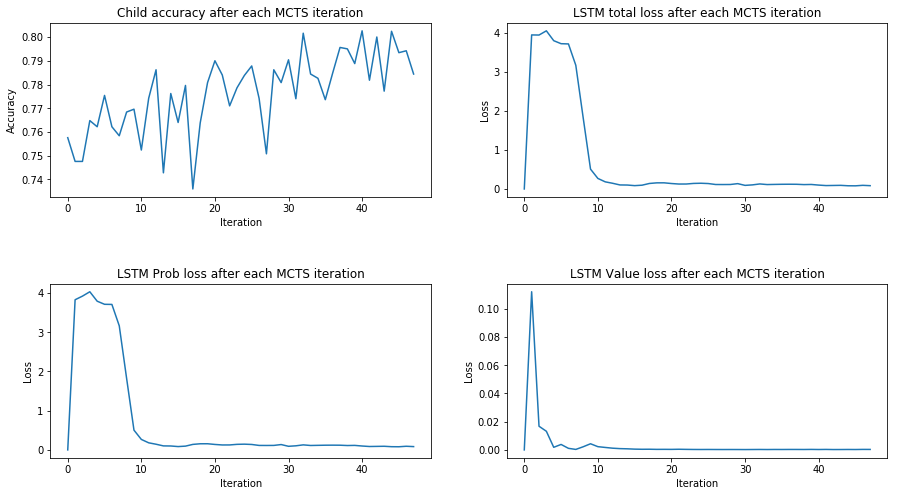

In [21]:
plot_mcts_resuts(total_result)

The progress of the Couch / MCTS search can be observed by 4 metrics through time:<br>
<li> Accuracy of Child Models after a complete search iteration increases over time
<li> LSTM Loss - the LSTM model learns to initialize new states of MCTS, correctly
<li> LSTM Probability Loss - the LSTM model learns to initialize probability of actions given a new states of MCTS, correctly (part of LSTM Loss)
<li> LSTM Value Loss - the LSTM model learns to initialize value given a new states of MCTS, correctly (part of LSTM Loss)   

Next, the only the accuracy and different architectures are printed from the log files.<br>
<br>
The Coach discovers many different archtectires during the search process

In [22]:
print_diff_architectures_to_jupyter(total_result)

################ New Final Train ################
Architecture
[[0, 0, 'convsep_5x5', 'conv_7x7', 'add'], [0, 0, 'id_', 'conv_3x3', 'concat'], [2, 1, 'conv_5x5', 'conv_7x7', 'add'], [3, 3, 'conv_5x5', 'conv_7x7', 'concat']]
Accuracy 0.7576121794871795
################ New Final Train ################
Architecture
[[0, 0, 'convsep_7x7', 'id_', 'concat'], [0, 1, 'convsep_5x5', 'id_', 'add'], [1, 2, 'conv_1x1', 'conv_1x1', 'concat'], [3, 3, 'conv_3x3', 'id_', 'concat']]
Accuracy 0.7475961538461539
################ New Final Train ################
Architecture
[[0, 0, 'convsep_5x5', 'convsep_3x3', 'add'], [1, 0, 'avgpool_3x3', 'conv_7x7', 'add'], [2, 0, 'convsep_3x3', 'conv_1x1', 'concat'], [0, 3, 'id_', 'conv_3x3', 'add']]
Accuracy 0.7475961538461539
################ New Final Train ################
Architecture
[[0, 0, 'conv_1x1', 'conv_7x7', 'add'], [1, 1, 'id_', 'conv_5x5', 'add'], [1, 0, 'conv_1x1', 'conv_5x5', 'concat'], [0, 0, 'conv_3x3', 'conv_7x7', 'concat']]
Accuracy 0.7648237179

Finally, the index and architecture of the best results are printed

In [23]:
best_index = get_index_best_archteicture(total_result)
best_index

40

In [24]:
total_result[best_index]['final_convcell']

[[0, 0, 'conv_3x3', 'conv_3x3', 'concat'],
 [1, 1, 'conv_7x7', 'conv_7x7', 'concat'],
 [0, 2, 'conv_5x5', 'conv_3x3', 'concat'],
 [2, 1, 'conv_1x1', 'conv_7x7', 'concat']]

In [25]:
# Creating a path for retraining
createPath('./exp/MultipleMCTS/Retrained_Models/')

<a id='retrain11'></a>
## 2.3. Retraining the model for more epochs

The best network architecture is selected and it will be retrained with new initialized weights with the similar hypterparamter as ResNet or DenseNet (40 epochs and learning rate decay after 20 and 30 epochs). ResNet / DenseNet hyperparameter are based on iteration instead of epochs.

In [26]:
# Get normal cell structure
convcell = total_result[best_index]['final_convcell']

In [27]:
tf.reset_default_graph()

In [28]:
# Initialize weights
with tf.variable_scope('GLOBAL_WEIGHTS'): 
    GLOBAL_WEIGHTS = create_weights(N_numberofconv, N_convcells, B, action_space, no_channels_start)
    GLOBAL_WEIGHTS[-1] = {}
    GLOBAL_WEIGHTS[-1][0] = get_weights(str('Start_1'), [1, 
                                                         1, 
                                                         3, 
                                                         no_channels_start])
    GLOBAL_WEIGHTS[-2]  = {}

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
variables_not_initialize = [x for x in tf.global_variables()]

In [30]:
# Initialize Child Model
createPath('./exp/MultipleMCTS/Retrained_Models/MultipleMCTS_NoChange')
"""
        Function __init__

        Initialize the ChildModel model - save paramaters as attributes

        Args:
            sess (Tensorflow session): Tensorflow session, where the parameters are saved
            images (dict): Images used for training ChildModel
            labels (dict): Labels used for training ChildModel 
            path (str): Directory to store ChildModel files
            batch_size (int): Batch size for training Child Model 
            convcell (list): A list of operation for the convolutional cell
            global_ops (list): Not used anymore 
            global_param (list): List with some global parameters
            childname (str): The ChildModel name
            variables_not_initialize (list): List of tensorflow weights not to initialize
            no_channels_start (int): Number of default filter size
        
        Attributes:
            width (int): Number of image width
            height (int): Number of height height
            channels (int): Number of channels in image
            num_classes (int): Number of classes
"""
model = ChildModel(sess,
                   images, 
                   labels, 
                   './exp/MultipleMCTS/Retrained_Models/MultipleMCTS_NoChange/', 
                   64, 
                   convcell, 
                   global_ops, 
                   global_param, 
                   'no_architecture_change',
                   variables_not_initialize,
                   no_channels_start)

In [31]:
# Build the model
model.build_model(GLOBAL_WEIGHTS)

----------
1 0
----------
1 1
----------
1 2
----------
1 3
----------
1 4
----------
1 5
----------
1 6
----------
1 7
----------
1 8
----------
1 9
----------
1 10
----------
1 11
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [32]:
# Train the Child Model
# Dont execute as it takes 0.5 days to train
if False:
    """
        Function child_model.couch_train

        Predict the data in batches as it could be too big to fit in the GPU memory, at once.

        Args:
            images (dict): Images used for training ChildModel
            labels (dict): Labels used for training ChildModel 
            max_noimprovements (int): Stop training ChildModel if does not improve over number of epochs
            max_iteration (int): Number of maximal training steps in ChildModel
            lr_iteration_step (list): Epochs when learning rate is decayed in ChildModel
            max_epochs (int): Number of epochs for training ChildModel
            no_global_variables (boolean): If True, no global variables are trained in ChildModel
            safe_model (boolean): If True, then ChildModel weights are safed
    """
    model.couch_train(images, 
                      labels,
                      50, 
                      1000000, 
                      [20, 30], 
                      40, 
                      False, 
                      safe_model = True)

In [33]:
# Reload trained model
model.reload_model(sess, './exp/MultipleMCTS/Retrained_Models/MultipleMCTS_NoChange/model/no_architecture_change')

INFO:tensorflow:Restoring parameters from ./exp/MultipleMCTS/Retrained_Models/MultipleMCTS_NoChange/model/no_architecture_change


In [34]:
# Predict validation set
val_acc = model.predict_validation(images['valid'], labels['valid'], 0, initialize_new = False)

In [35]:
# Predict test set
test_acc = model.predict_validation(images['test'], labels['test'], 0, initialize_new = False)

In [36]:
# Print
print('Validation Accuracy: ' + str(val_acc))
print('Test Accuracy: ' + str(test_acc))

Validation Accuracy: 0.8563701923076923
Test Accuracy: 0.850761217948718


<a id='retrain12'></a>
## 2.4. Retraining the model for more epochs and 18 normal cells

Similar to the aboe training, the best normal cell architecture is trained for 18 normal cells instead of 12.
As the rest of the code stays constat, no additional commets are made

In [37]:
N_convcells = 18
global_ops = []
global_param = [N_numberofconv, N_convcells, B, action_space, no_channels_start]

In [38]:
convcell = total_result[best_index]['final_convcell']

In [39]:
tf.reset_default_graph()

In [40]:
with tf.variable_scope('GLOBAL_WEIGHTS'): 
    GLOBAL_WEIGHTS = create_weights(N_numberofconv, N_convcells, B, action_space, no_channels_start)
    GLOBAL_WEIGHTS[-1] = {}
    GLOBAL_WEIGHTS[-1][0] = get_weights(str('Start_1'), [1, 
                                                         1, 
                                                         3, 
                                                         no_channels_start])
    GLOBAL_WEIGHTS[-2]  = {}

In [41]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
variables_not_initialize = [x for x in tf.global_variables()]

In [42]:
createPath('./exp/MultipleMCTS/Retrained_Models/MultipleMCTS_18ConvCells')
model = ChildModel(sess,
                   images, 
                   labels, 
                   './exp/MultipleMCTS/Retrained_Models/MultipleMCTS_18ConvCells/', 
                   64, 
                   convcell, 
                   global_ops, 
                   global_param, 
                   'convcell18_change',
                   variables_not_initialize,
                   no_channels_start)

In [43]:
model.build_model(GLOBAL_WEIGHTS)

----------
1 0
----------
1 1
----------
1 2
----------
1 3
----------
1 4
----------
1 5
----------
1 6
----------
1 7
----------
1 8
----------
1 9
----------
1 10
----------
1 11
----------
1 12
----------
1 13
----------
1 14
----------
1 15
----------
1 16
----------
1 17


In [44]:
# Train the Child Model
# Dont execute as it takes 0.5 days to train
if False:
    model.couch_train(images, 
                      labels,
                      50, 
                      1000000, 
                      [20, 30], 
                      40, 
                      False, 
                      safe_model = True)

In [45]:
# Reload trained model
model.reload_model(sess, './exp/MultipleMCTS/Retrained_Models/MultipleMCTS_18ConvCells/model/convcell18_change')

INFO:tensorflow:Restoring parameters from ./exp/MultipleMCTS/Retrained_Models/MultipleMCTS_18ConvCells/model/convcell18_change


In [46]:
val_acc = model.predict_validation(images['valid'], labels['valid'], 0, initialize_new = False)

In [47]:
test_acc = model.predict_validation(images['test'], labels['test'], 0, initialize_new = False)

In [48]:
print('Validation Accuracy: ' + str(val_acc))
print('Test Accuracy: ' + str(test_acc))

Validation Accuracy: 0.7698317307692307
Test Accuracy: 0.7524038461538461


<a id='nas2'></a>
# 3. NAS with efficient one MCTS expansions

The paper AlphaX does not reinitialize the MCTS and continue training over all iteration with the same statics. The below part is equivalent to Multiple MCTS expansions except of, that it never reinitalize the MCTS and each action is expanded only once.

The rest is as above and therefore, no additioncal comments are added

<a id='train2'></a>
## 3.1. Train/Search

In [49]:
# Dont execute as it takes 4 days to train
if False:
    """
        Function Coach.__init__

        Initialize the Couach - save paramaters as attributes

        Args:
            path (str): Directory to store all files
            GLOBAL_WEIGHTS (dict): Dictonary with shared tensorflow weights
            num_learning_iteration (int): Number of iteration to train 
            num_expansions (int): Number of tree search for a given state
            B (int): Number of inconv cells
            action_space (dict): Dictionary with possible neural network operations + weights
            combine_op (dict): Dictionary with possible combine operations + weights
            size_lstm (int): Size of hidden layer in LSTM; 
            sess (None): Not used anymore
            max_replay_size (int): Number of replay size to train LSTM
            images (dict): Images used for training ChildModel
            labels (dict): Labels used for training ChildModel 
            global_ops (list): Not used anymore 
            global_param (list): List with some global parameters
            no_channels_start (int): Number of channels in convolution layer
            search_perc_range (list): Percentage range of data used for child model (only first value is used)
            search_epoch_range (list): Number of epochs range for child model (only first value is used)
            N_convcells_range (int): Number of convcells used
            no_for_uniform (int): Number of learning iteration (Tree), which uses a uniform distribution for Ps
            new_mcts_every_i (int): Every number of learning iteration (Tree), reinitizalize MCTS tree
            alphax_version (boolean): If True other MCTS formula is used (based on AlphaX paper)
            debug_no_trainig (boolean): If True no ChildModel are trained and only dummy value is returned
        
        Attributes:
            num_actions (int): Number of total actions possible (used for LSTM prediction)
            full_examples (list): Stores replay for training LSTM
            max_noimprovements (int): Stop training ChildModel if does not improve over number of epochs
            max_iteration (int): Number of maximal training steps in ChildModel
            lr_iteration_step (list): Epochs when learning rate is decayed in ChildModel
            max_epochs (int): Number of epochs for training ChildModel
            no_global_variables (boolean): If True, no global variables are trained in ChildModel
            lstm_batchsize (int): Batchsize for training LSTM model
            lstm_learning_rate (float): Learning rate for LSTM model
            no_trained_in_search (int): Counter for number of ChildModel in MCTS Search trained
            no_trained_final (int): Counter for number of ChildModel trained in the end of one iteration_learning
    """
    coach = Coach('exp/OneMCTS', 
                  [], 
                  num_learning_iteration = 5000, 
                  num_expansions = 1,
                  B = B,
                  action_space = action_space, 
                  combine_op = combine_op,
                  size_lstm = 100, 
                  sess = None,
                  max_replay_size = 1000, 
                  images = images, 
                  labels = labels, 
                  global_ops = global_ops, 
                  global_param = global_param,
                  no_channels_start = no_channels_start,
                  search_perc_range = [0.3, 0.5],
                  search_epoch_range = [6, 6],
                  N_convcells_range = [6, 7],
                  no_for_uniform = 1001, 
                  new_mcts_every_i = 1001,
                  alphax_version = False,
                  debug_no_trainig = False
                 )
    coach.train()

In [ ]:
# Execute trainig in debug modus (no child training) - can be executed for testing/grading
coach = Coach('exp/OneMCTS_debug', 
              [], 
              num_learning_iteration = 10, # less iterations
              num_expansions = 1,
              B = B,
              action_space = action_space, 
              combine_op = combine_op,
              size_lstm = 100, 
              sess = None,
              max_replay_size = 1000, 
              images = images, 
              labels = labels, 
              global_ops = global_ops, 
              global_param = global_param,
              no_channels_start = no_channels_start,
              search_perc_range = [0.3, 0.5],
              search_epoch_range = [6, 6],
              N_convcells_range = [6, 7],
              no_for_uniform = 1001, 
              new_mcts_every_i = 1001,
              alphax_version = False,
              debug_no_trainig = True
             )
coach.train()

<a id='results2'></a>
## 3.2. Results

In [51]:
filename = './exp/OneMCTS/Coach/logs.txt'
print_files_to_jupyter(filename)

###################################### New Search ###################################### 

Trained final: 0 Trained in search:0 

LSTM percentage: 0.3 LSTM Epoch:6 Size:(13500, 32, 32, 3) 

NConvcell: 6 

Use uniform: True

MCTS State: (0, 0, 4, 4, 14, 1, 1, 4, 4, 14, 1, 0, 4, 4, 14, 2, 1, 4, 4, 14) MCTS cell: [[0, 0, 'conv_3x3', 'conv_3x3', 'add'], [1, 1, 'conv_3x3', 'conv_3x3', 'add'], [1, 0, 'conv_3x3', 'conv_3x3', 'add'], [2, 1, 'conv_3x3', 'conv_3x3', 'add']]

In search iteration: 0 v value: 0.39242788461538464 for (0, 0, 4, 4, 14, 1, 1, 4, 4, 14, 1, 0, 4, 4, 14, 2, 1, 4) 

Full state: (0, 0, 4, 4, 14, 1, 1, 4, 4, 14, 1, 0, 4, 4, 14, 2, 1, 4, 4, 14) convcell: [[0, 0, 'conv_3x3', 'conv_3x3', 'add'], [1, 1, 'conv_3x3', 'conv_3x3', 'add'], [1, 0, 'conv_3x3', 'conv_3x3', 'add'], [2, 1, 'conv_3x3', 'conv_3x3', 'add']] 

MCTS State: (0, 0, 4, 4, 14, 1, 1, 4, 4, 14, 1, 0, 4, 4, 14, 2, 1, 4, 5, 14) MCTS cell: [[0, 0, 'conv_3x3', 'conv_3x3', 'add'], [1, 1, 'conv_3x3', 'conv_3x3', 'add'], [

LSTM Total loss: 0.13469115 Loss prob: 0.13436206 Loss value: 0.00032908568

B LSTM Total loss: 0.1331104 B Loss prob: 0.13283266 B Loss value: 0.00027774982

LSTM Total loss: 0.1331104 Loss prob: 0.13283266 Loss value: 0.00027774982

B LSTM Total loss: 0.32059276 B Loss prob: 0.32017815 B Loss value: 0.000414614

LSTM Total loss: 0.32059276 Loss prob: 0.32017815 Loss value: 0.000414614

B LSTM Total loss: 0.28235525 B Loss prob: 0.28191528 B Loss value: 0.0004399708

LSTM Total loss: 0.28235525 Loss prob: 0.28191528 Loss value: 0.0004399708

B LSTM Total loss: 0.18381353 B Loss prob: 0.18349263 B Loss value: 0.00032089476

LSTM Total loss: 0.18381353 Loss prob: 0.18349263 Loss value: 0.00032089476

B LSTM Total loss: 0.14478263 B Loss prob: 0.14449172 B Loss value: 0.00029091228

LSTM Total loss: 0.14478263 Loss prob: 0.14449172 Loss value: 0.00029091228

B LSTM Total loss: 0.22698124 B Loss prob: 0.22639605 B Loss value: 0.0005851872

LSTM Total loss: 0.22698124 Loss prob: 0.22639605

B LSTM Total loss: 0.15262201 B Loss prob: 0.15249163 B Loss value: 0.0001303851

LSTM Total loss: 0.15262201 Loss prob: 0.15249163 Loss value: 0.0001303851

B LSTM Total loss: 0.08433748 B Loss prob: 0.08423793 B Loss value: 9.95472e-05

LSTM Total loss: 0.08433748 Loss prob: 0.08423793 Loss value: 9.95472e-05

B LSTM Total loss: 0.13585147 B Loss prob: 0.13572639 B Loss value: 0.0001250782

LSTM Total loss: 0.13585147 Loss prob: 0.13572639 Loss value: 0.0001250782

B LSTM Total loss: 0.07443254 B Loss prob: 0.07432857 B Loss value: 0.00010396736

LSTM Total loss: 0.07443254 Loss prob: 0.07432857 Loss value: 0.00010396736

B LSTM Total loss: 0.044556376 B Loss prob: 0.04450758 B Loss value: 4.879258e-05

LSTM Total loss: 0.044556376 Loss prob: 0.04450758 Loss value: 4.879258e-05

B LSTM Total loss: 0.07748142 B Loss prob: 0.07743734 B Loss value: 4.4079487e-05

LSTM Total loss: 0.07748142 Loss prob: 0.07743734 Loss value: 4.4079487e-05

B LSTM Total loss: 0.03997151 B Loss prob: 0.039


B LSTM Total loss: 0.04291543 B Loss prob: 0.04281061 B Loss value: 0.00010481868

LSTM Total loss: 0.04291543 Loss prob: 0.04281061 Loss value: 0.00010481868

B LSTM Total loss: 0.07289357 B Loss prob: 0.07282655 B Loss value: 6.701802e-05

LSTM Total loss: 0.07289357 Loss prob: 0.07282655 Loss value: 6.701802e-05

B LSTM Total loss: 0.0977721 B Loss prob: 0.09773995 B Loss value: 3.2149463e-05

LSTM Total loss: 0.0977721 Loss prob: 0.09773995 Loss value: 3.2149463e-05

###################################### New Search ###################################### 

Trained final: 112 Trained in search:114 

LSTM percentage: 0.3 LSTM Epoch:6 Size:(13500, 32, 32, 3) 

NConvcell: 6 

Use uniform: True

MCTS State: (0, 0, 6, 11, 14, 1, 0, 4, 4, 14, 0, 0, 4, 4, 14, 0, 0, 4, 4, 14) MCTS cell: [[0, 0, 'conv_7x7', 'convsep_7x7', 'add'], [1, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add']]

In search iteration: 0 v value: 0.62540064102


LSTM Total loss: 0.08660129 Loss prob: 0.08656275 Loss value: 3.853561e-05

B LSTM Total loss: 0.10460679 B Loss prob: 0.10455067 B Loss value: 5.612801e-05

LSTM Total loss: 0.10460679 Loss prob: 0.10455067 Loss value: 5.612801e-05

B LSTM Total loss: 0.09333907 B Loss prob: 0.09329645 B Loss value: 4.26185e-05

LSTM Total loss: 0.09333907 Loss prob: 0.09329645 Loss value: 4.26185e-05

B LSTM Total loss: 0.029934376 B Loss prob: 0.029870503 B Loss value: 6.387448e-05

LSTM Total loss: 0.029934376 Loss prob: 0.029870503 Loss value: 6.387448e-05

B LSTM Total loss: 0.076710604 B Loss prob: 0.07662867 B Loss value: 8.193524e-05

LSTM Total loss: 0.076710604 Loss prob: 0.07662867 Loss value: 8.193524e-05

B LSTM Total loss: 0.055688992 B Loss prob: 0.055577163 B Loss value: 0.00011182887

LSTM Total loss: 0.055688992 Loss prob: 0.055577163 Loss value: 0.00011182887

B LSTM Total loss: 0.008039502 B Loss prob: 0.00795905 B Loss value: 8.0452766e-05

LSTM Total loss: 0.008039502 Loss prob:

LSTM Total loss: 0.028661331 Loss prob: 0.028608203 Loss value: 5.3128046e-05

B LSTM Total loss: 0.07247328 B Loss prob: 0.072375424 B Loss value: 9.7857956e-05

LSTM Total loss: 0.07247328 Loss prob: 0.072375424 Loss value: 9.7857956e-05

B LSTM Total loss: 0.09452293 B Loss prob: 0.09442572 B Loss value: 9.72102e-05

LSTM Total loss: 0.09452293 Loss prob: 0.09442572 Loss value: 9.72102e-05

B LSTM Total loss: 0.02312178 B Loss prob: 0.023048008 B Loss value: 7.377201e-05

LSTM Total loss: 0.02312178 Loss prob: 0.023048008 Loss value: 7.377201e-05

B LSTM Total loss: 0.18917139 B Loss prob: 0.18912736 B Loss value: 4.4026998e-05

LSTM Total loss: 0.18917139 Loss prob: 0.18912736 Loss value: 4.4026998e-05

B LSTM Total loss: 0.039218456 B Loss prob: 0.0391611 B Loss value: 5.735383e-05

LSTM Total loss: 0.039218456 Loss prob: 0.0391611 Loss value: 5.735383e-05

B LSTM Total loss: 0.07788861 B Loss prob: 0.07781732 B Loss value: 7.128974e-05

LSTM Total loss: 0.07788861 Loss prob: 0.07


B LSTM Total loss: 0.060188018 B Loss prob: 0.060025178 B Loss value: 0.00016283814

LSTM Total loss: 0.060188018 Loss prob: 0.060025178 Loss value: 0.00016283814

B LSTM Total loss: 0.0956731 B Loss prob: 0.09560311 B Loss value: 6.999062e-05

LSTM Total loss: 0.0956731 Loss prob: 0.09560311 Loss value: 6.999062e-05

B LSTM Total loss: 0.056493055 B Loss prob: 0.056364443 B Loss value: 0.00012861183

LSTM Total loss: 0.056493055 Loss prob: 0.056364443 Loss value: 0.00012861183

B LSTM Total loss: 0.059477586 B Loss prob: 0.05924602 B Loss value: 0.00023156698

LSTM Total loss: 0.059477586 Loss prob: 0.05924602 Loss value: 0.00023156698

B LSTM Total loss: 0.030220035 B Loss prob: 0.03011244 B Loss value: 0.00010759564

LSTM Total loss: 0.030220035 Loss prob: 0.03011244 Loss value: 0.00010759564

B LSTM Total loss: 0.09830855 B Loss prob: 0.0981184 B Loss value: 0.00019014678

LSTM Total loss: 0.09830855 Loss prob: 0.0981184 Loss value: 0.00019014678

B LSTM Total loss: 0.09726448 B L

In [52]:
filename = './exp/OneMCTS/Coach/total_results.pickle'
total_result = load_pickle(filename)

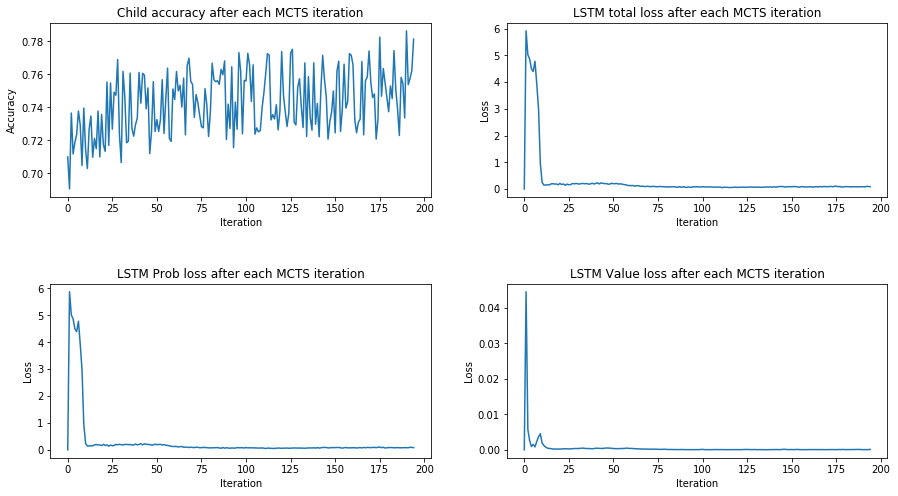

In [53]:
plot_mcts_resuts(total_result)

In [54]:
print_diff_architectures_to_jupyter(total_result)
best_index = get_index_best_archteicture(total_result)

################ New Final Train ################
Architecture
[[0, 0, 'conv_3x3', 'conv_3x3', 'add'], [1, 1, 'conv_3x3', 'conv_3x3', 'add'], [1, 0, 'conv_3x3', 'conv_3x3', 'add'], [2, 1, 'conv_3x3', 'conv_5x5', 'concat']]
Accuracy 0.7099358974358975
################ New Final Train ################
Architecture
[[0, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 1, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add']]
Accuracy 0.6905048076923077
################ New Final Train ################
Architecture
[[0, 0, 'conv_3x3', 'conv_7x7', 'concat'], [0, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add']]
Accuracy 0.7365785256410257
################ New Final Train ################
Architecture
[[0, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 1, 'conv_3x3', 'conv_3x3', 'add'], [2, 0, 'conv_3x3', 'conv_3x3', 'add'], [0, 0, 'conv_3x3', 'conv_3x3', 'add']]
Accuracy 0.711738782051282
###

In [55]:
best_index

190

In [56]:
total_result[best_index]['final_convcell_acc']

0.7864583333333334

In [57]:
total_result[best_index]['final_convcell']

[[0, 0, 'conv_7x7', 'conv_7x7', 'add'],
 [1, 1, 'conv_3x3', 'conv_3x3', 'add'],
 [0, 0, 'conv_3x3', 'conv_3x3', 'add'],
 [0, 0, 'conv_3x3', 'conv_3x3', 'add']]

In [59]:
createPath('./exp/OneMCTS/Retrained_Models/')

<a id='retrain21'></a>
## 3.3. Retraining the model for more epochs

In [60]:
N_convcells = 12
global_ops = []
global_param = [N_numberofconv, N_convcells, B, action_space, no_channels_start]

In [61]:
convcell = total_result[best_index]['final_convcell']

In [62]:
tf.reset_default_graph()

In [63]:
with tf.variable_scope('GLOBAL_WEIGHTS'): 
    GLOBAL_WEIGHTS = create_weights(N_numberofconv, N_convcells, B, action_space, no_channels_start)
    GLOBAL_WEIGHTS[-1] = {}
    GLOBAL_WEIGHTS[-1][0] = get_weights(str('Start_1'), [1, 
                                                         1, 
                                                         3, 
                                                         no_channels_start])
    GLOBAL_WEIGHTS[-2]  = {}

In [64]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
variables_not_initialize = [x for x in tf.global_variables()]

In [65]:
createPath('./exp/OneMCTS/Retrained_Models/OneMCTS_nochange')
model = ChildModel(sess,
                   images, 
                   labels, 
                   './exp/OneMCTS/Retrained_Models/OneMCTS_nochange/', 
                   64, 
                   convcell, 
                   global_ops, 
                   global_param, 
                   'no_change',
                   variables_not_initialize,
                   no_channels_start)

In [66]:
model.build_model(GLOBAL_WEIGHTS)

----------
1 0
----------
1 1
----------
1 2
----------
1 3
----------
1 4
----------
1 5
----------
1 6
----------
1 7
----------
1 8
----------
1 9
----------
1 10
----------
1 11


In [ ]:
# Train the Child Model
# Dont execute as it takes 0.5 days to train
if False:
    model.couch_train(images, 
                      labels,
                      50, 
                      1000000, 
                      [20, 30], 
                      40, 
                      False, 
                      safe_model = True)

In [67]:
# Reload trained model
model.reload_model(sess, './exp/OneMCTS/Retrained_Models/OneMCTS_nochange/model/no_change')

INFO:tensorflow:Restoring parameters from ./exp/OneMCTS/Retrained_Models/OneMCTS_nochange/model/no_change


In [68]:
val_acc = model.predict_validation(images['valid'], labels['valid'], 0, initialize_new = False)

In [69]:
test_acc = model.predict_validation(images['test'], labels['test'], 0, initialize_new = False)

In [70]:
print('Validation Accuracy: ' + str(val_acc))
print('Test Accuracy: ' + str(test_acc))

Validation Accuracy: 0.8469551282051282
Test Accuracy: 0.8414463141025641


<a id='retrain22'></a>
## 3.4. Retraining the model for more epochs and 18 normal cells

In [71]:
N_convcells = 18
global_ops = []
global_param = [N_numberofconv, N_convcells, B, action_space, no_channels_start]

In [72]:
convcell = total_result[best_index]['final_convcell']

In [73]:
tf.reset_default_graph()

In [74]:
with tf.variable_scope('GLOBAL_WEIGHTS'): 
    GLOBAL_WEIGHTS = create_weights(N_numberofconv, N_convcells, B, action_space, no_channels_start)
    GLOBAL_WEIGHTS[-1] = {}
    GLOBAL_WEIGHTS[-1][0] = get_weights(str('Start_1'), [1, 
                                                         1, 
                                                         3, 
                                                         no_channels_start])
    GLOBAL_WEIGHTS[-2]  = {}

In [75]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
variables_not_initialize = [x for x in tf.global_variables()]

In [76]:
createPath('./exp/OneMCTS/Retrained_Models/OneMCTS_18incell')
model = ChildModel(sess,
                   images, 
                   labels, 
                   './exp/OneMCTS/Retrained_Models/OneMCTS_18incell/', 
                   64, 
                   convcell, 
                   global_ops, 
                   global_param, 
                   'incell18_change',
                   variables_not_initialize,
                   no_channels_start)

In [77]:
model.build_model(GLOBAL_WEIGHTS)

----------
1 0
----------
1 1
----------
1 2
----------
1 3
----------
1 4
----------
1 5
----------
1 6
----------
1 7
----------
1 8
----------
1 9
----------
1 10
----------
1 11
----------
1 12
----------
1 13
----------
1 14
----------
1 15
----------
1 16
----------
1 17


In [78]:
# Train the Child Model
# Dont execute as it takes 0.5 days to train
if False:
    model.couch_train(images, 
                      labels,
                      50, 
                      1000000, 
                      [20, 30], 
                      40, 
                      False, 
                      safe_model = True)

In [80]:
# Reload trained model
model.reload_model(sess, './exp/OneMCTS/Retrained_Models/OneMCTS_18incell/model/incell18_change')

INFO:tensorflow:Restoring parameters from ./exp/OneMCTS/Retrained_Models/OneMCTS_18incell/model/incell18_change


In [81]:
val_acc = model.predict_validation(images['valid'], labels['valid'], 0, initialize_new = False)

In [82]:
test_acc = model.predict_validation(images['test'], labels['test'], 0, initialize_new = False)

In [83]:
print('Validation Accuracy: ' + str(val_acc))
print('Test Accuracy: ' + str(test_acc))

Validation Accuracy: 0.789863782051282
Test Accuracy: 0.7741386217948718
